In [1]:
from __future__ import division
from __future__ import print_function
import numpy as np
import torch
import torch.optim as optim
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import *
from models import *
from PIL import Image
!mkdir generated_images


A subdirectory or file generated_images already exists.


In [2]:
lr_gen = 0.0006 #Learning rate for generator
lr_dis = 0.0003 #Learning rate for discriminator
latent_dim = 256 #Latent dimension
epoch = 200 #Number of epoch
weight_decay = 1e-3 #Weight decay
drop_rate = 0.5 #dropout

# architecture details by authors
image_size = 64 #H,W size of image for discriminator
initial_size = 8 #Initial size for generator
patch_size = 4 #Patch size for generated image
num_classes = 1 #Number of classes for discriminator 
output_dir = 'checkpoint' #saved model path
dim = 384 #Embedding dimension
phi = 4 #
beta1 = 0.9 #
beta2 = 0.99 #
diff_aug = "translation,cutout,color" #data augmentation


In [3]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"


generator = (
    Generator(
        depth1=5,
        depth2=3,
        depth3=1,
        initial_size=16,
        dim=512,
        heads=3,
        mlp_ratio=6,
        drop_rate=0.5,
        latent_dim=256,
    )
    .to(device)
    .apply(inits_weight)
)

discriminator = (
    Discriminator(
        diff_aug=diff_aug,
        image_size=64,
        patch_size=8,
        input_channel=1,
        num_classes=1,
        dim=384,
        depth=3,
        heads=4,
        mlp_ratio=2,
        drop_rate=0.5,
    )
    .to(device)
    .apply(inits_weight)
)

optim_gen = optim.AdamW(
    filter(lambda p: p.requires_grad, generator.parameters()),
    lr=lr_gen,
    betas=(beta1, beta2),
)
optim_dis = optim.AdamW(
    filter(lambda p: p.requires_grad, discriminator.parameters()),
    lr=lr_dis,
    betas=(beta1, beta2),
)

gen_scheduler = LinearLrDecay(optim_gen, lr_gen, 0.0, 0, max_iter * n_critic)
dis_scheduler = LinearLrDecay(optim_dis, lr_dis, 0.0, 0, max_iter * n_critic)

c:\Users\aashr\Desktop\research\testing_grounds\utils.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data, 1.)


1

In [6]:
def compute_gradient_penalty(D, real_samples, fake_samples, phi):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.Tensor(np.random.random((real_samples.size(0), 1, 1, 1))).to(
        real_samples.get_device()
    )
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(
        True
    )
    d_interpolates = D(interpolates)
    fake = torch.ones([real_samples.shape[0], 1], requires_grad=False).to(
        real_samples.get_device()
    )
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.contiguous().view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - phi) ** 2).mean()
    return gradient_penalty

In [7]:
img_size = 64
transform = transforms.Compose(
        [
            transforms.Resize(size=(img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Grayscale(1)
        ]
    )

    # train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_set = torchvision.datasets.ImageFolder(
        root=r"C:\Users\aashr\Desktop\research\testing_grounds\images",
        transform=transform,
    )
train_loader = torch.utils.data.DataLoader(
        dataset=train_set, batch_size=6, shuffle=True
    )

def train(
    noise,
    generator,
    discriminator,
    optim_gen,
    optim_dis,
    epoch,
    gen_scheduler,
    dis_scheduler,
    latent_dim=latent_dim,
    device="cuda:0",
):
    generator = generator.train()
    discriminator = discriminator.train()

    for index, (img, _) in enumerate(train_loader):

        real_imgs = img.type(torch.cuda.FloatTensor)
        noise = torch.cuda.FloatTensor(
            np.random.normal(0, 1, (img.shape[0], latent_dim))
        )

        optim_dis.zero_grad()
        real_valid = discriminator(real_imgs)
        fake_imgs = generator(noise).detach()
        fake_valid = discriminator(fake_imgs)

        gradient_penalty = compute_gradient_penalty(
            discriminator, real_imgs, fake_imgs.detach(), phi
        )
        (
            -torch.mean(real_valid)
            + torch.mean(fake_valid)
            + gradient_penalty * 10 / (phi**2)
        ).backward()
        optim_dis.step()

        optim_gen.zero_grad()
        g_lr = gen_scheduler.step()
        d_lr = dis_scheduler.step()

        gener_noise = torch.cuda.FloatTensor(np.random.normal(0, 1, (6, latent_dim)))
        generated_imgs = generator(gener_noise)
        fake_valid = discriminator(generated_imgs)
        gener_loss = -torch.mean(fake_valid).to(device)
        gener_loss.backward()
        optim_gen.step()
    save_image(
        generated_imgs,
        f"generated_images/generated_img_{epoch}_{index % len(train_loader)}.png",
    )
    display(
        Image.open(
            f"generated_images/generated_img_{epoch}_{index % len(train_loader)}.png"
        )
    )
    tqdm.write(f"[Epoch {epoch+1}] [Batch {index+1}/{len(train_loader)}] [D loss: {los_dis.item()}] [G loss: {gener_loss.item()}] [D lr: {d_lr}] [G lr: {g_lr}]")

C:\Users\aashr\AppData\Roaming\Python\Python310\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3436.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


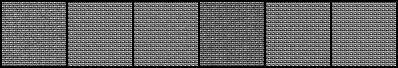

[Epoch 1] [Batch 394/395] [D loss: -102.683441] [G loss: 56.170570]


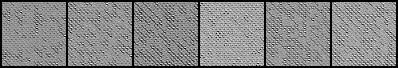

[Epoch 2] [Batch 394/395] [D loss: 11.852088] [G loss: 112.129913]


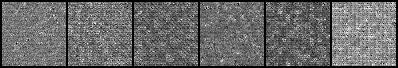

[Epoch 3] [Batch 394/395] [D loss: 93.159668] [G loss: -8.566982]


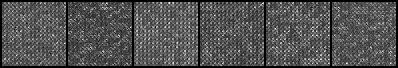

[Epoch 4] [Batch 394/395] [D loss: 42.330200] [G loss: 14.529938]


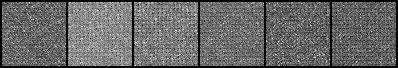

[Epoch 5] [Batch 394/395] [D loss: 26.077682] [G loss: 20.498188]


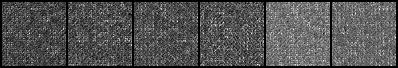

[Epoch 6] [Batch 394/395] [D loss: 5.003605] [G loss: 30.346676]


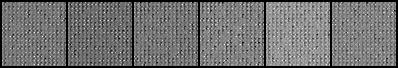

[Epoch 7] [Batch 394/395] [D loss: 16.077934] [G loss: 32.290169]


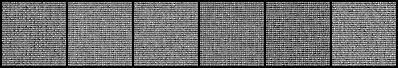

[Epoch 8] [Batch 394/395] [D loss: -12.677492] [G loss: 28.734915]


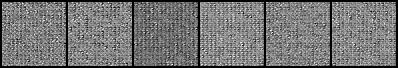

[Epoch 9] [Batch 394/395] [D loss: 7.043470] [G loss: 25.648891]


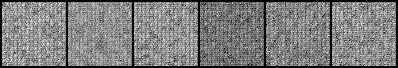

[Epoch 10] [Batch 394/395] [D loss: 12.256656] [G loss: 13.883389]


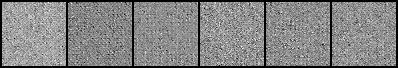

[Epoch 11] [Batch 394/395] [D loss: 5.477831] [G loss: 10.906006]


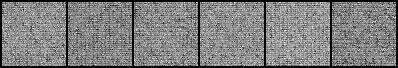

[Epoch 12] [Batch 394/395] [D loss: 14.448395] [G loss: 7.491482]


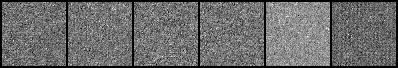

[Epoch 13] [Batch 394/395] [D loss: 30.029264] [G loss: -4.947776]


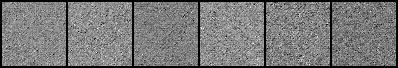

[Epoch 14] [Batch 394/395] [D loss: 6.840185] [G loss: -2.058282]


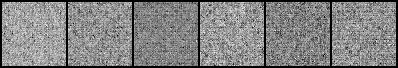

[Epoch 15] [Batch 394/395] [D loss: 24.400679] [G loss: 0.447636]


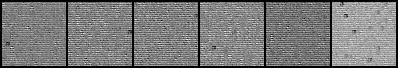

[Epoch 16] [Batch 394/395] [D loss: -2.212420] [G loss: 76.053055]


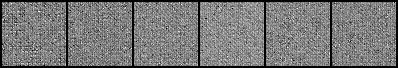

[Epoch 17] [Batch 394/395] [D loss: 11.089943] [G loss: 39.661331]


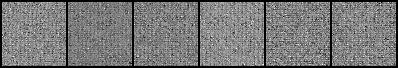

[Epoch 18] [Batch 394/395] [D loss: 8.435909] [G loss: 24.292194]


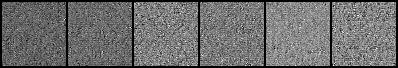

[Epoch 19] [Batch 394/395] [D loss: 129.829391] [G loss: 1.943544]


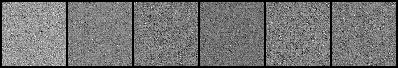

[Epoch 20] [Batch 394/395] [D loss: 7.620551] [G loss: 41.560848]


In [8]:

epoch = 2000
for epoch in range(epoch):
    train(
        noise,
        generator,
        discriminator,
        optim_gen,
        optim_dis,
        epoch,
        gen_scheduler,
        dis_scheduler,
        latent_dim=latent_dim,
    )